In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import re
import string
%matplotlib inline
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import pickle
import os
sns.set(font_scale=0.8)
sns.set_style({"figure.facecolor": "None"})

from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV


/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load data scarped from office box mojo
df = pd.read_json("mojo.json")

# load data scarped from office The Numbers
financials=pd.read_csv("budget.csv", encoding="UTF-8", sep="|",header=None)


# Phase 1: clean data

## clean gross

In [4]:

df["domestic_gross"]=df["domestic_gross"].str.replace("n/a","0")
df["domestic_gross_clnd"]=df["domestic_gross"].apply(lambda x: int(re.sub('['+string.punctuation+']', '', x).strip()))
df["worldwide_gross_clnd"]=df["worldwide_gross"].apply(lambda x: 0 if x==0 else int(re.sub('['+string.punctuation+']', '', x).strip()))
df["worldwide_gross_clnd_log"]=df["worldwide_gross_clnd"].apply(lambda x: np.log(x+1))
df["domestic_gross_clnd_log"]=df["domestic_gross_clnd"].apply(lambda x: np.log(x+1))


## clean budget

In [5]:
# first check
df["budget"][0:5]


0    $70 million
1    $20 million
2    $14 million
3    $35 million
4            N/A
Name: budget, dtype: object

In [6]:
#percentage invalid ones
(df["budget"]=="N/A").sum()/len(df)
#I need another source


0.7486481073502904

In [7]:
def clean_budget(x):
    budg_reg=re.compile("\$(.*) million", re.IGNORECASE)
    budg=None
    matches = re.search(budg_reg, x)
    if matches!=None:
            budg=float(matches.group(1))*1000000
    return(budg)
df["budget_cleaned"]=df["budget"].apply( clean_budget)

## Clean data from The Numbers

In [8]:
financials.columns=["name","URL_Numb","Budget_Numb","Domestic_Numb","WWide_Numb","o"]

In [9]:
df["name"]=df["name"].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', x).replace('  ', ' ').strip().lower())
financials["name"]=financials["name"].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', x).replace('  ', ' ').strip().lower())

In [10]:
del financials["o"]

In [11]:
# merge The Numbers and Mojo db
df=df.merge(financials, on='name',how="left", indicator=True)

In [12]:
# Normalize budget, domand int gross from the Numbers

mask=df["Budget_Numb"].notnull()
df.loc[mask,"Budget_Numb_clnd"]=df.loc[mask,"Budget_Numb"].apply(lambda x: int(re.sub('['+string.punctuation+']', '', x).strip()))

mask=df["Domestic_Numb"].notnull()
df.loc[mask,"Domestic_Numb_clnd"]=df.loc[mask,"Domestic_Numb"].apply(lambda x: 0 if x==0 else int(re.sub('['+string.punctuation+']', '', x).strip()))

mask=df["WWide_Numb"].notnull()
df.loc[mask,"WWide_Numb_clnd"]=df.loc[mask,"WWide_Numb"].apply(lambda x: 0 if x==0 else int(re.sub('['+string.punctuation+']', '', x).strip()))


In [13]:
mask=((df["budget_cleaned"].isnull())&(df["Budget_Numb_clnd"].notnull()))

In [14]:
mask.sum()

1207

In [15]:
# Thanks to The Numbers, I could fill 1207 missing values in Mojo db

In [16]:
df.loc[mask, "budget_cleaned"]=df.loc[mask, "Budget_Numb_clnd"]

In [17]:
mask=df["budget"].notnull()
df.loc[mask,"domestic_gross_to_budget"]=df.apply(lambda row: row["domestic_gross_clnd"]/row["budget_cleaned"],axis=1)
df.loc[mask,"ww_gross_to_budget"]=df.apply(lambda row: row["worldwide_gross_clnd"]/row["budget_cleaned"],axis=1)

In [18]:
# Fill N/A in budget as median value of bujet by genre )

In [19]:
A=df.groupby(["main_genre"]).median()["budget_cleaned"]
median_budget_by_genre=A.dropna().to_dict()

In [20]:
mask=df["budget_cleaned"].isnull()
mask.sum()

6367

In [21]:
df.loc[mask, "budget_cleaned"]=df.loc[mask].apply(lambda row: median_budget_by_genre[row["main_genre"]] if row["main_genre"] in median_budget_by_genre else np.nan,axis=1 )

In [22]:
mask=df["budget_cleaned"].isnull()
mask.sum()

# I could fill nearly all N/A in budget

2

## clean MPAA

In [23]:
# priliminary check 
df["mpaa"].value_counts()

R                3393
Unrated          2916
PG-13            2032
PG               1371
G                 269
Not Yet Rated      27
NC-17              22
Unknown             3
M                   2
Name: mpaa, dtype: int64

In [24]:
# Let's standardize:
# We will group Unknown, Unrated and Unrated in 1 category called Unrated

# M is an old rating (until 1970), meaning
# "Suggested for Mature Audiences – parental discretion advised"
# It seems equivalent to either PG or PG-13 in current rating system. 
# It does not make big difference though, given that it is only 2 of them
# Transform M to PG

In [25]:
df['mpaa'].replace("M", "PG", inplace=True)
df['mpaa'].replace(["Not Yet Rated","Unknown" ], "Unrated", inplace=True)

In [26]:
df["mpaa"].value_counts()

R          3393
Unrated    2946
PG-13      2032
PG         1373
G           269
NC-17        22
Name: mpaa, dtype: int64

In [27]:
# create dummy variables
dummies = pd.get_dummies(df['mpaa'])
df = pd.concat([df, dummies], axis=1)

## clean Distributor

In [28]:
list_of_ditributors=df['distributor'].value_counts().reset_index()


In [29]:
# there are many small disitributors. 
#I will group those with less than 50 movied 
# into one single label called "small dostributors"

list_of_ditributors.columns=["distributor","count"]

In [30]:
small_distributors=list_of_ditributors[list_of_ditributors["count"]<50]

In [31]:
small_distributors=list(small_distributors["distributor"])

small_distributors

['Kino',
 'Fine Line',
 'Freestyle Releasing',
 'Cohen Media Group',
 'Palm',
 'Cannon Films',
 'Yash Raj',
 'CJ Entertainment',
 'United Artists',
 'Abramorama',
 'Indican',
 'Gramercy',
 'Paramount Classics',
 'Variance Films',
 'Paramount (DreamWorks)',
 'IDP',
 'Open Road Films',
 'Lionsgate/Summit',
 'Sony (Revolution)',
 'Icarus Films',
 'International Film Circuit',
 'Artisan',
 'Wellspring',
 'Radius-TWC',
 'First Look',
 'October',
 'New World',
 'A24',
 'Orion Classics',
 'Rialto',
 'Anchor Bay Films',
 'Drafthouse',
 'Summit Entertainment',
 'TLA Releasing',
 'GKIDS',
 'Alliance',
 'Cinema Libre Studio',
 'Eleven Arts',
 'Trimark',
 'Vitagraph',
 'Dimension Films',
 'Rocky Mountain Pictures',
 'Relativity',
 'Shadow Dist.',
 'Weinstein / Dimension',
 'The Orchard',
 'Janus Films',
 'Fathom',
 'Tribeca Film',
 'Balcony Releasing',
 '7th Art',
 'Tartan',
 'Argot Pictures',
 'Monterey Media, Inc.',
 'Reliance Big Pictures',
 'USA Films',
 'FIP',
 'Distrib Films',
 'Warner Indep

In [32]:
small_distributors.extend(["Picturehouse (II)",                        
"Cineplex small_distributor",               
"Full small_distributor Releasing",         
"small_distributor/Zeitgeist Films",        
"PMK*BNC",                                  
"Cansmall_distributor Films",               
"small_distributor/small_distributor",      
"Crimson Films/PMK*BNC" ])

In [33]:
for distr in small_distributors:
    df["distributor"]=df["distributor"].str.replace(distr,"small_distributor")

## clean Run Time

In [34]:
def extract_run_time(x):
    time_reg=re.compile("(.*) hr.* (.*) min", re.IGNORECASE)
    matches = re.search(time_reg, x)
    if matches is None:
        return (np.NaN)
    return(int(matches.group(1))*60+int(matches.group(2)))
df["run_time_clnd"]=df['run_time'].apply(extract_run_time)

## clean nominations and the oscars prize won


In [35]:
#calculate the number of oscar nomination and oscars won  
import re
def get_oscar_nominations(x):
    nominations_reg=re.compile("Nominated For (.*) Oscar", re.IGNORECASE)
    nominations="zero"
    matches = re.search(nominations_reg, x)
    if matches!=None:
        nominations=matches.group(1).lower()
    return(nominations)

def get_oscars_won(x):
    wins_reg=re.compile("Including (.*) Win", re.IGNORECASE)
    wins="zero"
    matches = re.search(wins_reg, x)
    if matches!=None:
        wins=matches.group(1).lower()
    return(wins)

In [36]:
df["oscars_win_cleaned"]=df["oscar_wins"].apply(get_oscars_won)
df["oscars_nomination_cleaned"]=df["oscar_nominations"].apply(get_oscar_nominations)

In [37]:
numbers={"zero":0,
         "one":1,
        "two":2,
        "three":3,
        "four":4,
        "five":5,
        "six":6,
        "seven":7,
        "eight":8,
        "nine":9,
        "ten":10,
        "eleven":11,
        "twelve":12,
        "thirteen":13,
        "fourteen":14}

In [38]:
# check before transforming 
df["oscars_win_cleaned"].value_counts()

zero      9724
one        190
two         54
three       27
four        18
five         8
six          5
seven        5
eleven       2
eight        1
nine         1
Name: oscars_win_cleaned, dtype: int64

In [39]:
# transfrom numbers from string to integers
df["oscars_nomination_cleaned"]=df["oscars_nomination_cleaned"].apply(lambda x: numbers[x])
df["oscars_win_cleaned"]=df["oscars_win_cleaned"].apply(lambda x: numbers[x])

## Extract and clean the release month

In [40]:
# apparently no null case for the release date
df["release_date"].isnull().sum()

0

In [41]:
df["release_date"].value_counts().head(5)

September 13, 2013    17
October 4, 2013       17
N/A                   17
September 21, 2012    17
October 20, 2017      16
Name: release_date, dtype: int64

In [42]:
#because of inconsistent date, format I cannot use the TimeSeries.
#first I splito on " " and then I get the first subgroup
df["release_month"]=df["release_date"].apply(lambda x: x.split(" ")[0].lower())

In [43]:
# check 
df["release_month"].value_counts()

august       971
october      966
september    915
march        901
april        879
july         841
june         840
november     822
may          795
december     754
february     720
january      610
n/a           17
1984           1
1991           1
fall           1
2009           1
Name: release_month, dtype: int64

In [44]:
# drop the few lines few inconsistencies (I need the release month )
errors=["n/a","fall","2009","1991","1984"]
df=df[~df["release_month"].isin(errors)]

In [45]:
dict_month={"august":8,
"october":10,
"september":9,
"march":3,
"april":4,
"july":7,
"june":6,
"november":11,
"may":5,
"december":12,
"february":2,
"january":1}

In [46]:
mask=df["release_month"].notnull()
df.loc[mask,"release_month"]=df.loc[mask,"release_month"].apply(lambda x: dict_month[x] )

## Extract and clean the release year

In [47]:
# I need the release year to adjust financials to tehir 2018 value
df["release_year"]=df["release_date"].apply(lambda x: x.split(" ")[-1].lower())

## extract and clean Opening Weekend data

In [48]:
names=df["name"]
op_we = pd.read_json("opening_weekend_new.json")
del op_we["dom_gross"]
op_we.shape
op_we=op_we[(op_we["opening_we_gross"]!="n/a") & (op_we["opening_release"]!="n/a")]
op_we.shape
op_we["opening_release"]=op_we["opening_release"].apply(lambda x: int(re.sub('['+string.punctuation+']', '', x).strip()))
op_we["opening_we_gross"]=op_we["opening_we_gross"].apply(lambda x: int(re.sub('['+string.punctuation+']', '', x).strip()))
op_we["title"]=op_we["title"].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', x).replace('  ', ' ').strip().lower())
dict_op_we=dict()
for i in op_we.index:
    dict_op_we[op_we.loc[i]["title"]]=(op_we.loc[i,"opening_release"],op_we.loc[i,"opening_we_gross"])

counter_y=0
counter_n=0
for n in names:
        if n in dict_op_we:
            counter_y+=1
        else:
            counter_n+=1
print(counter_y,counter_n)
df["theater_opening_we"]=df["name"].apply(lambda x: dict_op_we[x][0] if x in  dict_op_we else None )
df["gross_opening_we"]=df["name"].apply(lambda x: dict_op_we[x][1] if x in  dict_op_we else None)


9407 607


# Phase 2: adjustments and transformations

## Adjust financials to 2018

In [49]:
release_years=list(df["release_year"].unique())

In [50]:
# Scraped the translating factor for Gross from Mojo through Selenium
# Adjusted only 1 movie per year and found the xxxx-> 2018 adjustment 
# factor for that year. I then I applied the same factor to all
# movies released in that particularl year.

# The process has been done once and then 
# saved in a picke named inflaction_rates.pkl.
# this is not to repeat this time consuming operation 
# any rtime I need to run this notebook.

# if this file not present in the working directory, 
# uncomment this cell
'''
adjusting_factor_domestic_gross=defaultdict(int)
for yr in release_years:
    url=df[df["release_year"]==yr].iloc[0].url
    # mv chrome driver from Downloads to Applications 
    chromedriver = "/Applications/chromedriver"
    os.environ["webdriver.chrome.driver"] = chromedriver
    driver = webdriver.Chrome(chromedriver)
    driver.get(url)
    ticketyr = driver.find_element_by_name("ticketyr")
    ticketyr.send_keys("2018")
    go = driver.find_element_by_name("Go")
    go.send_keys(Keys.RETURN)
    A=driver.find_elements_by_xpath("//*[contains(text(), 'Domestic Total Adj')]")
    adjusted=int(A[0].text.split("$")[-1].replace(",",""))
    original=int(driver.find_elements_by_xpath('//td[@align="right"]/b')[0].text.split("$")[-1].replace(",",""))
    adjusting_factor_domestic_gross[yr]=adjusted/original
    driver.close()
pickle.dump( adjusting_factor_domestic_gross, open( "adjusting_factor_domestic_gross.pkl", "wb" ) )   
'''

'\nadjusting_factor_domestic_gross=defaultdict(int)\nfor yr in release_years:\n    url=df[df["release_year"]==yr].iloc[0].url\n    # mv chrome driver from Downloads to Applications \n    chromedriver = "/Applications/chromedriver"\n    os.environ["webdriver.chrome.driver"] = chromedriver\n    driver = webdriver.Chrome(chromedriver)\n    driver.get(url)\n    ticketyr = driver.find_element_by_name("ticketyr")\n    ticketyr.send_keys("2018")\n    go = driver.find_element_by_name("Go")\n    go.send_keys(Keys.RETURN)\n    A=driver.find_elements_by_xpath("//*[contains(text(), \'Domestic Total Adj\')]")\n    adjusted=int(A[0].text.split("$")[-1].replace(",",""))\n    original=int(driver.find_elements_by_xpath(\'//td[@align="right"]/b\')[0].text.split("$")[-1].replace(",",""))\n    adjusting_factor_domestic_gross[yr]=adjusted/original\n    driver.close()\npickle.dump( adjusting_factor_domestic_gross, open( "adjusting_factor_domestic_gross.pkl", "wb" ) )   \n'

In [51]:
adjusting_factor_domestic_gross=pickle.load(open( "adjusting_factor_domestic_gross.pkl", "rb" ) )

In [52]:
# Found the inflaction factor to applie to budget with the same process followed
# for the gross.

# The adjusting factor for budget is not the same as that for gross.
# this is because mojo calculates the adjsuting factor as a combination
# of factors: inflation + another adjustment that take care of
# theatres price increas.

# done once and saved in a picke named inflaction_rates.pkl.
# if this file not present in the working directory, 
# uncomment this cell
'''
inflaction_rate=defaultdict(int)
for yr in release_years:
    chromedriver = "/Applications/chromedriver"
    os.environ["webdriver.chrome.driver"] = chromedriver
    driver = webdriver.Chrome(chromedriver)
    driver.get("https://data.bls.gov/cgi-bin/cpicalc.pl")
    amount = driver.find_element_by_name("cost1")
    amount.send_keys("1")

    starting_yr = driver.find_element_by_id("year1-year")
    starting_yr.send_keys(yr)

    ending_yr = driver.find_element_by_id("year1-year")
    ending_yr.send_keys("2017")

    go = driver.find_element_by_id("submit")
    go.send_keys("2017")
    go.send_keys(Keys.RETURN)

    answer=driver.find_element_by_id("answer")
    inflaction_rate[yr]=float(answer.text.split("$")[-1])
    driver.close()
pickle.dump( inflaction_rate, open( "inflaction_rates.pkl", "wb" ) )
'''

'\ninflaction_rate=defaultdict(int)\nfor yr in release_years:\n    chromedriver = "/Applications/chromedriver"\n    os.environ["webdriver.chrome.driver"] = chromedriver\n    driver = webdriver.Chrome(chromedriver)\n    driver.get("https://data.bls.gov/cgi-bin/cpicalc.pl")\n    amount = driver.find_element_by_name("cost1")\n    amount.send_keys("1")\n\n    starting_yr = driver.find_element_by_id("year1-year")\n    starting_yr.send_keys(yr)\n\n    ending_yr = driver.find_element_by_id("year1-year")\n    ending_yr.send_keys("2017")\n\n    go = driver.find_element_by_id("submit")\n    go.send_keys("2017")\n    go.send_keys(Keys.RETURN)\n\n    answer=driver.find_element_by_id("answer")\n    inflaction_rate[yr]=float(answer.text.split("$")[-1])\n    driver.close()\npickle.dump( inflaction_rate, open( "inflaction_rates.pkl", "wb" ) )\n'

In [53]:
inflaction_rate=pickle.load(open( "inflaction_rates.pkl", "rb" ) )

## Adjusting gross

In [54]:
# now that we have the factors we can apply the adjustment
mask=df["domestic_gross_clnd"]!=0
df.loc[mask, "domestic_gross_clnd_adj"]=\
 df.loc[mask].apply(lambda row: row["domestic_gross_clnd"]\
                    *adjusting_factor_domestic_gross[row["release_year"]],axis=1)

In [55]:
mask=df["Domestic_Numb_clnd"]!=0
df.loc[mask, "domestic_Numb_clnd_adj"]=\
 df.loc[mask].apply(lambda row: row["Domestic_Numb_clnd"]\
                    *adjusting_factor_domestic_gross[row["release_year"]],axis=1)

In [56]:
mask=df["domestic_gross_clnd"]!=0
df.loc[mask, "domestic_gross_clnd_INFL_ONLY_adj"]=\
 df.loc[mask].apply(lambda row: row["domestic_gross_clnd"]\
                    *inflaction_rate[row["release_year"]],axis=1)

In [57]:
mask=df["Domestic_Numb_clnd"]!=0
df.loc[mask, "domestic_numb_clnd_INFL_ONLY_adj"]=\
 df.loc[mask].apply(lambda row: row["Domestic_Numb_clnd"]\
                    *inflaction_rate[row["release_year"]],axis=1)

In [58]:
mask=df["worldwide_gross_clnd"]!=0
df.loc[mask, "worldwide_gross_clnd_adj"]=\
 df.loc[mask].apply(lambda row: row["worldwide_gross_clnd"]\
                    *adjusting_factor_domestic_gross[row["release_year"]],axis=1)

In [59]:
mask=df["WWide_Numb_clnd"]!=0
df.loc[mask, "WWide_Numb_clnd_adj"]=\
 df.loc[mask].apply(lambda row: row["WWide_Numb_clnd"]\
                    *adjusting_factor_domestic_gross[row["release_year"]],axis=1)

In [60]:
mask=df["WWide_Numb_clnd"]!=0
df.loc[mask, "WWide_Numb_clnd_INFL_ONLY_adj"]=\
 df.loc[mask].apply(lambda row: row["WWide_Numb_clnd"]\
                    *inflaction_rate[row["release_year"]],axis=1)

In [61]:
mask=df["worldwide_gross_clnd"]!=0
df.loc[mask, "worldwide_gross_clnd_INFL_ONLY_adj"]=\
 df.loc[mask].apply(lambda row: row["worldwide_gross_clnd"]\
                    *inflaction_rate[row["release_year"]],axis=1)

## Adjusting opening weekend gross

In [144]:
mask=df["gross_opening_we"]!=0
df.loc[mask, "gross_opening_we_adj"]=\
 df.loc[mask].apply(lambda row: row["gross_opening_we"]\
                    *adjusting_factor_domestic_gross[row["release_year"]],axis=1)

## Adjusting budget

In [63]:
mask=df["budget_cleaned"]!=0
df.loc[mask, "budget_adj"]=\
 df.loc[mask].apply(lambda row: row["budget_cleaned"]\
                    *inflaction_rate[row["release_year"]],axis=1)

In [64]:
mask=df["Budget_Numb_clnd"]!=0
df.loc[mask, "budget_numb_adj"]=\
 df.loc[mask].apply(lambda row: row["Budget_Numb_clnd"]\
                    *inflaction_rate[row["release_year"]],axis=1)

# Phase 3: feature engineering

In [ ]:
# first let's normalize both actors and directors
# lower, strip and remove punctuaction

In [65]:
def normalize_actors(list_of_names):
    if len(list_of_names)==0:
        return(np.NaN)
    else:
        return(list(map(lambda x: re.sub('['+string.punctuation+']', ' ', x).strip().lower(),list_of_names)))
    
df.loc[~df["Actor"].isnull(),"Actor"]=df.loc[~df["Actor"].isnull(),"Actor"].apply(normalize_actors)

In [66]:
def normalize_directors(list_of_names):
    if len(list_of_names)==0:
        return(np.NaN)
    else:
        return(list(map(lambda x: re.sub('['+string.punctuation+']', ' ', x).strip().lower(),list_of_names)))
df.loc[~df["Director"].isnull(),"Director"]=df.loc[~df["Director"].isnull(),"Director"].apply(normalize_directors)

## Actors

In [67]:
#build several dict with frequencies, Total ww and dom gross by actor 

tot_ww_gross_by_actor=defaultdict(int)
tot_dom_gross_by_actor=defaultdict(int)
dict_of_actors=defaultdict(int)
tot_ww_gross_by_actor_log=defaultdict(int)
tot_dom_gross_by_actor_log=defaultdict(int)

J=df[~df["Actor"].isnull()]
for ind in range(J.shape[0]):
    List_of_actors=J.iloc[ind]["Actor"]
    if List_of_actors!=[]:
        for actor in List_of_actors:
            tot_ww_gross_by_actor[actor]+=J.iloc[ind]["worldwide_gross_clnd"]
            tot_dom_gross_by_actor[actor]+=J.iloc[ind]["domestic_gross_clnd"]
            tot_ww_gross_by_actor_log[actor]+=J.iloc[ind]["worldwide_gross_clnd_log"]
            tot_dom_gross_by_actor_log[actor]+=J.iloc[ind]["domestic_gross_clnd_log"]
            dict_of_actors[actor]+=1


In [68]:
tot_dom_gross_by_actor["colin farrell"]

1284639676

In [69]:
#number of unique actors
#number of unique actors
len(dict_of_actors.values())
# too many fro a dummy variable

847

In [71]:
#build a dict with frequencies 
#it says the number of actors that played 1, 2, 3 etc movies
frequencies=defaultdict(int)
for k,v in dict_of_actors.items():
    frequencies[v]+=1

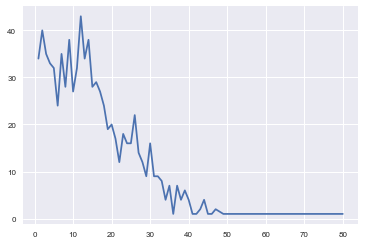

In [72]:

# plot frequencies
    
lists = sorted(frequencies.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.show()


In [73]:
# read file with all nominations 
oscars=pd.read_csv("nomination and wins.csv")

# extract only those relating to actor/ress
awards_roles=["Actress in a Supporting Role",
              "Actor in a Supporting Role",
              "Actress", 
              "Actor"]  
mask=oscars["Award"].isin(awards_roles)
oscars=oscars[mask]
years=list(map(lambda x: str(x),range(1960,2017)))
mask=oscars["Year"].isin(years)
oscars=oscars[mask]


# normalize names and create a dict with nom and prize per actor

oscars["Name"]=oscars["Name"].apply(lambda x:re.sub('['+string.punctuation+']', ' ', x).strip().lower())
win_found=defaultdict(int)
nomination_found=defaultdict(int)

mask=oscars["Winner"].isnull()
for o in oscars[mask]["Name"]:
    if o in dict_of_actors:
        nomination_found[o]+=1

mask=oscars["Winner"].notnull()
for o in oscars[mask]["Name"]:
    if o in dict_of_actors:
        win_found[o]+=1

In [74]:
# create dictionaries with normalized actor name as key and
# gross, oscar, nominations, number fo movies etc. as value
def actors_previous_movies_statistics(List_of_actors):
    count=0
    tot_ww_gross=0
    tot_dom_gross=0
    tot_ww_log_gross=0
    tot_dom_log_gross=0
    oscars_won=0
    nominations=0
    num_of_actors=len(List_of_actors)
    if num_of_actors==0:
        return(0,0,0,0,0)
    for actor in List_of_actors:
        tot_ww_gross+=tot_ww_gross_by_actor[actor]
        tot_dom_gross+=tot_dom_gross_by_actor[actor]
        tot_ww_log_gross+=tot_ww_gross_by_actor_log[actor]
        tot_dom_log_gross+=tot_dom_gross_by_actor_log[actor]
        count+=dict_of_actors[actor]
        if actor in win_found:
            oscars_won+=win_found[actor]
        if actor in nomination_found:
            nominations+=nomination_found[actor]
    #returns:
    #count 
    #avg_ww
    #avg_log_ww
    #avg_dom
    #avg_dom_log
    
    return count/num_of_actors,\
    tot_ww_gross/num_of_actors, \
    tot_ww_log_gross/num_of_actors,\
    tot_dom_gross/num_of_actors,\
    tot_dom_log_gross/num_of_actors,\
    oscars_won,\
    nominations

    # apply to df to find weighted average acrosscast by movie

mask=df["Actor"].notnull()
df.loc[mask,'actors_avg_cnt_prv_movies'],\
df.loc[mask,'actors_avg_ww_gross_prv_movies'],\
df.loc[mask,'actors_avg_ww_log_gross_prv_movies'],\
df.loc[mask,'actors_avg_dom_gross_prv_movies'],\
df.loc[mask,'actors_avg_dom_log_gross_prv_movies'],  \
df.loc[mask,'oscars_won_in_the_cast'],  \
df.loc[mask,'oscars_nominations_in_the_cast'] = \
zip(*df.loc[mask,"Actor"].map(actors_previous_movies_statistics))

## Directors

In [77]:
# Build the same dictionaries as for actors
tot_ww_gross_by_director=defaultdict(int)
tot_dom_gross_by_director=defaultdict(int)
dict_of_directors=defaultdict(int)
tot_ww_gross_by_director_log=defaultdict(int)
tot_dom_gross_by_director_log=defaultdict(int)
tot_oscars_nominations_by_director=defaultdict(int)
tot_oscars_prizes_by_director=defaultdict(int)
    
M=df[~df["Director"].isnull()]
for ind in range(M.shape[0]):
    List_of_directors=M.iloc[ind]["Director"]
    if List_of_directors!=[]:
        for director in List_of_directors:
            tot_ww_gross_by_director[director]+=M.iloc[ind]["worldwide_gross_clnd"]
            tot_dom_gross_by_director[director]+=M.iloc[ind]["domestic_gross_clnd"]
            tot_ww_gross_by_director_log[director]+=M.iloc[ind]["worldwide_gross_clnd_log"]
            tot_dom_gross_by_director_log[director]+=M.iloc[ind]["domestic_gross_clnd_log"]
            tot_oscars_nominations_by_director[director]+=M.iloc[ind]["oscars_nomination_cleaned"]
            tot_oscars_prizes_by_director[director]+=M.iloc[ind]["oscars_win_cleaned"] 
            dict_of_directors[director]+=1
           

In [78]:
len(dict_of_directors.values())

789

In [79]:
frequencies_directors=defaultdict(int)
for k,v in dict_of_directors.items():
    frequencies_directors[v]+=1

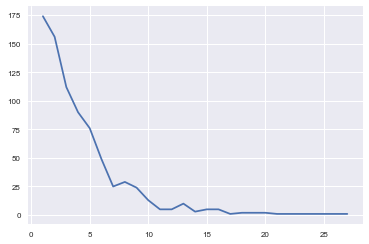

In [80]:
# plot number of movies per diretor
lists = sorted(frequencies_directors.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.show()

In [81]:
frequencies_directors.items()

dict_items([(16, 5), (8, 29), (18, 2), (2, 156), (27, 1), (6, 49), (3, 112), (7, 25), (4, 90), (10, 13), (5, 76), (13, 10), (17, 1), (9, 24), (1, 174), (14, 3), (12, 5), (15, 5), (11, 5), (20, 2), (25, 1), (21, 1)])

In [82]:
def directors_previous_movies_statistics(List_of_directors):
    if List_of_directors is None:
        return(N)
    count=0
    tot_ww_gross=0
    tot_dom_gross=0
    tot_ww_log_gross=0
    tot_dom_log_gross=0
    tot_oscar_nominations=0
    tot_oscar_wins=0
    
    num_of_directors=len(List_of_directors)
    if num_of_directors==0:
        return(0,0,0,0,0)
    for director in List_of_directors:
        tot_ww_gross+=tot_ww_gross_by_director[director]
        tot_dom_gross+=tot_dom_gross_by_director[director]
        tot_ww_log_gross+=tot_ww_gross_by_director_log[director]
        tot_dom_log_gross+=tot_dom_gross_by_director_log[director]
        count+=dict_of_directors[director]
        tot_oscar_nominations+=tot_oscars_nominations_by_director[director]
        tot_oscar_wins+=tot_oscars_prizes_by_director [director] 
        
               
    #returns:
    #count 
    #avg_ww
    #avg_log_ww
    #avg_dom
    #avg_dom_log
    #tot_nominations
    #tot_oscars_wins
    
    return count/num_of_directors, tot_ww_gross/num_of_directors, tot_ww_log_gross/num_of_directors,tot_dom_gross/num_of_directors, tot_dom_log_gross/num_of_directors,tot_oscar_nominations,  tot_oscar_wins

mask=df["Director"].notnull()

df.loc[mask,'directors_avg_cnt_prv_movies'],\
df.loc[mask,'directors_avg_ww_gross_prv_movies'],\
df.loc[mask,'directors_avg_ww_log_gross_prv_movies'],\
df.loc[mask,'directors_avg_dom_gross_prv_movies'],\
df.loc[mask,'directors_avg_dom_log_gross_prv_movies'],\
df.loc[mask,'directors_total_nominations'] ,\
df.loc[mask,'directors_oscars_won'] = \
zip(*df.loc[mask,"Director"].map(directors_previous_movies_statistics))

## Geners

In [84]:
genres_dict=defaultdict(int)

for ind in range(df.shape[0]):
    List_of_genres=df.iloc[ind]["genres"]
    if List_of_genres!=[]:
        for genre in List_of_genres:
            genres_dict[genre]+=1

In [85]:
list_of_geners=list(genres_dict.keys())

In [86]:
len(list_of_geners)

217

In [87]:
'''
df=df.reindex(columns=list(df.columns)+list_of_geners, fill_value=np.uint8(0))
for ind in df.index:
    for gener in df.loc[ind,"genres"]:
        df.loc[ind,gener]=np.uint8(1)
'''

'\ndf=df.reindex(columns=list(df.columns)+list_of_geners, fill_value=np.uint8(0))\nfor ind in df.index:\n    for gener in df.loc[ind,"genres"]:\n        df.loc[ind,gener]=np.uint8(1)\n'

In [88]:
df = df.rename(columns={'NC-17': 'NC_17', 'PG-13': 'PG_13'})

# Phase 4: transform

In [89]:
# Listo of columns to keep
columns_to_keep=[
 'theater_opening_we',
 'gross_opening_we_adj',
 'international_movie',
 'G',
 'NC_17',
 'PG',
 'PG_13',
 'R',
 'Unrated',
 'run_time_clnd',
 'oscars_win_cleaned',
 'oscars_nomination_cleaned',
 'release_month',
 'budget_adj',
 'actors_avg_cnt_prv_movies',
 'actors_avg_ww_gross_prv_movies',
 'actors_avg_ww_log_gross_prv_movies',
 'actors_avg_dom_gross_prv_movies',
 'actors_avg_dom_log_gross_prv_movies',
 'oscars_won_in_the_cast',
 'oscars_nominations_in_the_cast',
 'directors_avg_cnt_prv_movies',
 'directors_avg_ww_gross_prv_movies',
 'directors_avg_ww_log_gross_prv_movies',
 'directors_avg_dom_gross_prv_movies',
 'directors_avg_dom_log_gross_prv_movies',
 'directors_total_nominations',
 'directors_oscars_won',
 'budget_cleaned']

In [90]:
# create dummies by gener
dummies = pd.get_dummies(df['main_genre'])
columns_to_keep.extend(dummies.columns)
df = pd.concat([df, dummies], axis=1)


In [91]:
# create dummies by distributor
dummies = pd.get_dummies(df['distributor'])
df = pd.concat([df, dummies], axis=1)
columns_to_keep.extend(dummies.columns)


In [93]:
# drop rows with N/A
df = df.dropna(subset=columns_to_keep+["domestic_gross_clnd_adj"])

Text(0,0.5,'Domestic gross adjusted')

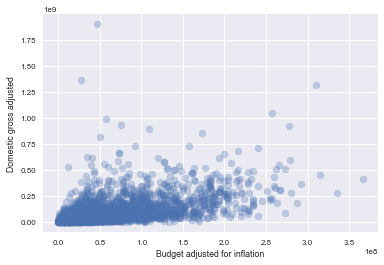

In [100]:
# plot of budjest (adjusted) vs domestic gross (adjusted) which is the dependent var
plt.scatter(df["budget_adj"],df["domestic_gross_clnd_adj"],alpha=0.3)
plt.xlabel("Budget adjusted for inflation")
plt.ylabel("Domestic gross adjusted")

Text(0,0.5,'Domestic gross adjusted (log)')

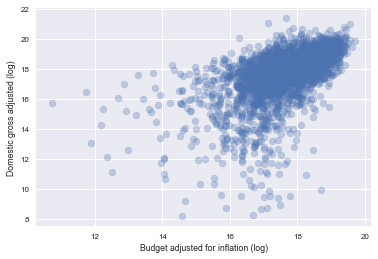

In [101]:
# plot of budjest (adjusted) vs domestic gross (adjusted) 
# in the log domain 
#better
plt.scatter(df["budget_adj"].apply(lambda x: np.log(x+1)),df["domestic_gross_clnd_adj"].apply(lambda x: np.log(x+1)),alpha=0.3)
plt.xlabel("Budget adjusted for inflation (log)")
plt.ylabel("Domestic gross adjusted (log)")

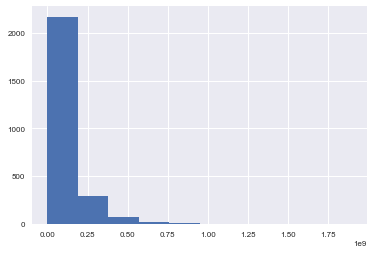

In [102]:
# plot the dep var. Power law
plt.hist(df["domestic_gross_clnd_adj"]);

In [103]:
columns_to_display=["domestic_gross_clnd_adj",
                    'budget_adj',
 'actors_avg_cnt_prv_movies',
 'actors_avg_ww_gross_prv_movies',
 'actors_avg_dom_gross_prv_movies',
 'oscars_won_in_the_cast',
 'oscars_nominations_in_the_cast',
 'directors_avg_cnt_prv_movies',
 'directors_avg_ww_gross_prv_movies',
 'directors_avg_dom_gross_prv_movies',
 'directors_total_nominations',
 'directors_oscars_won']

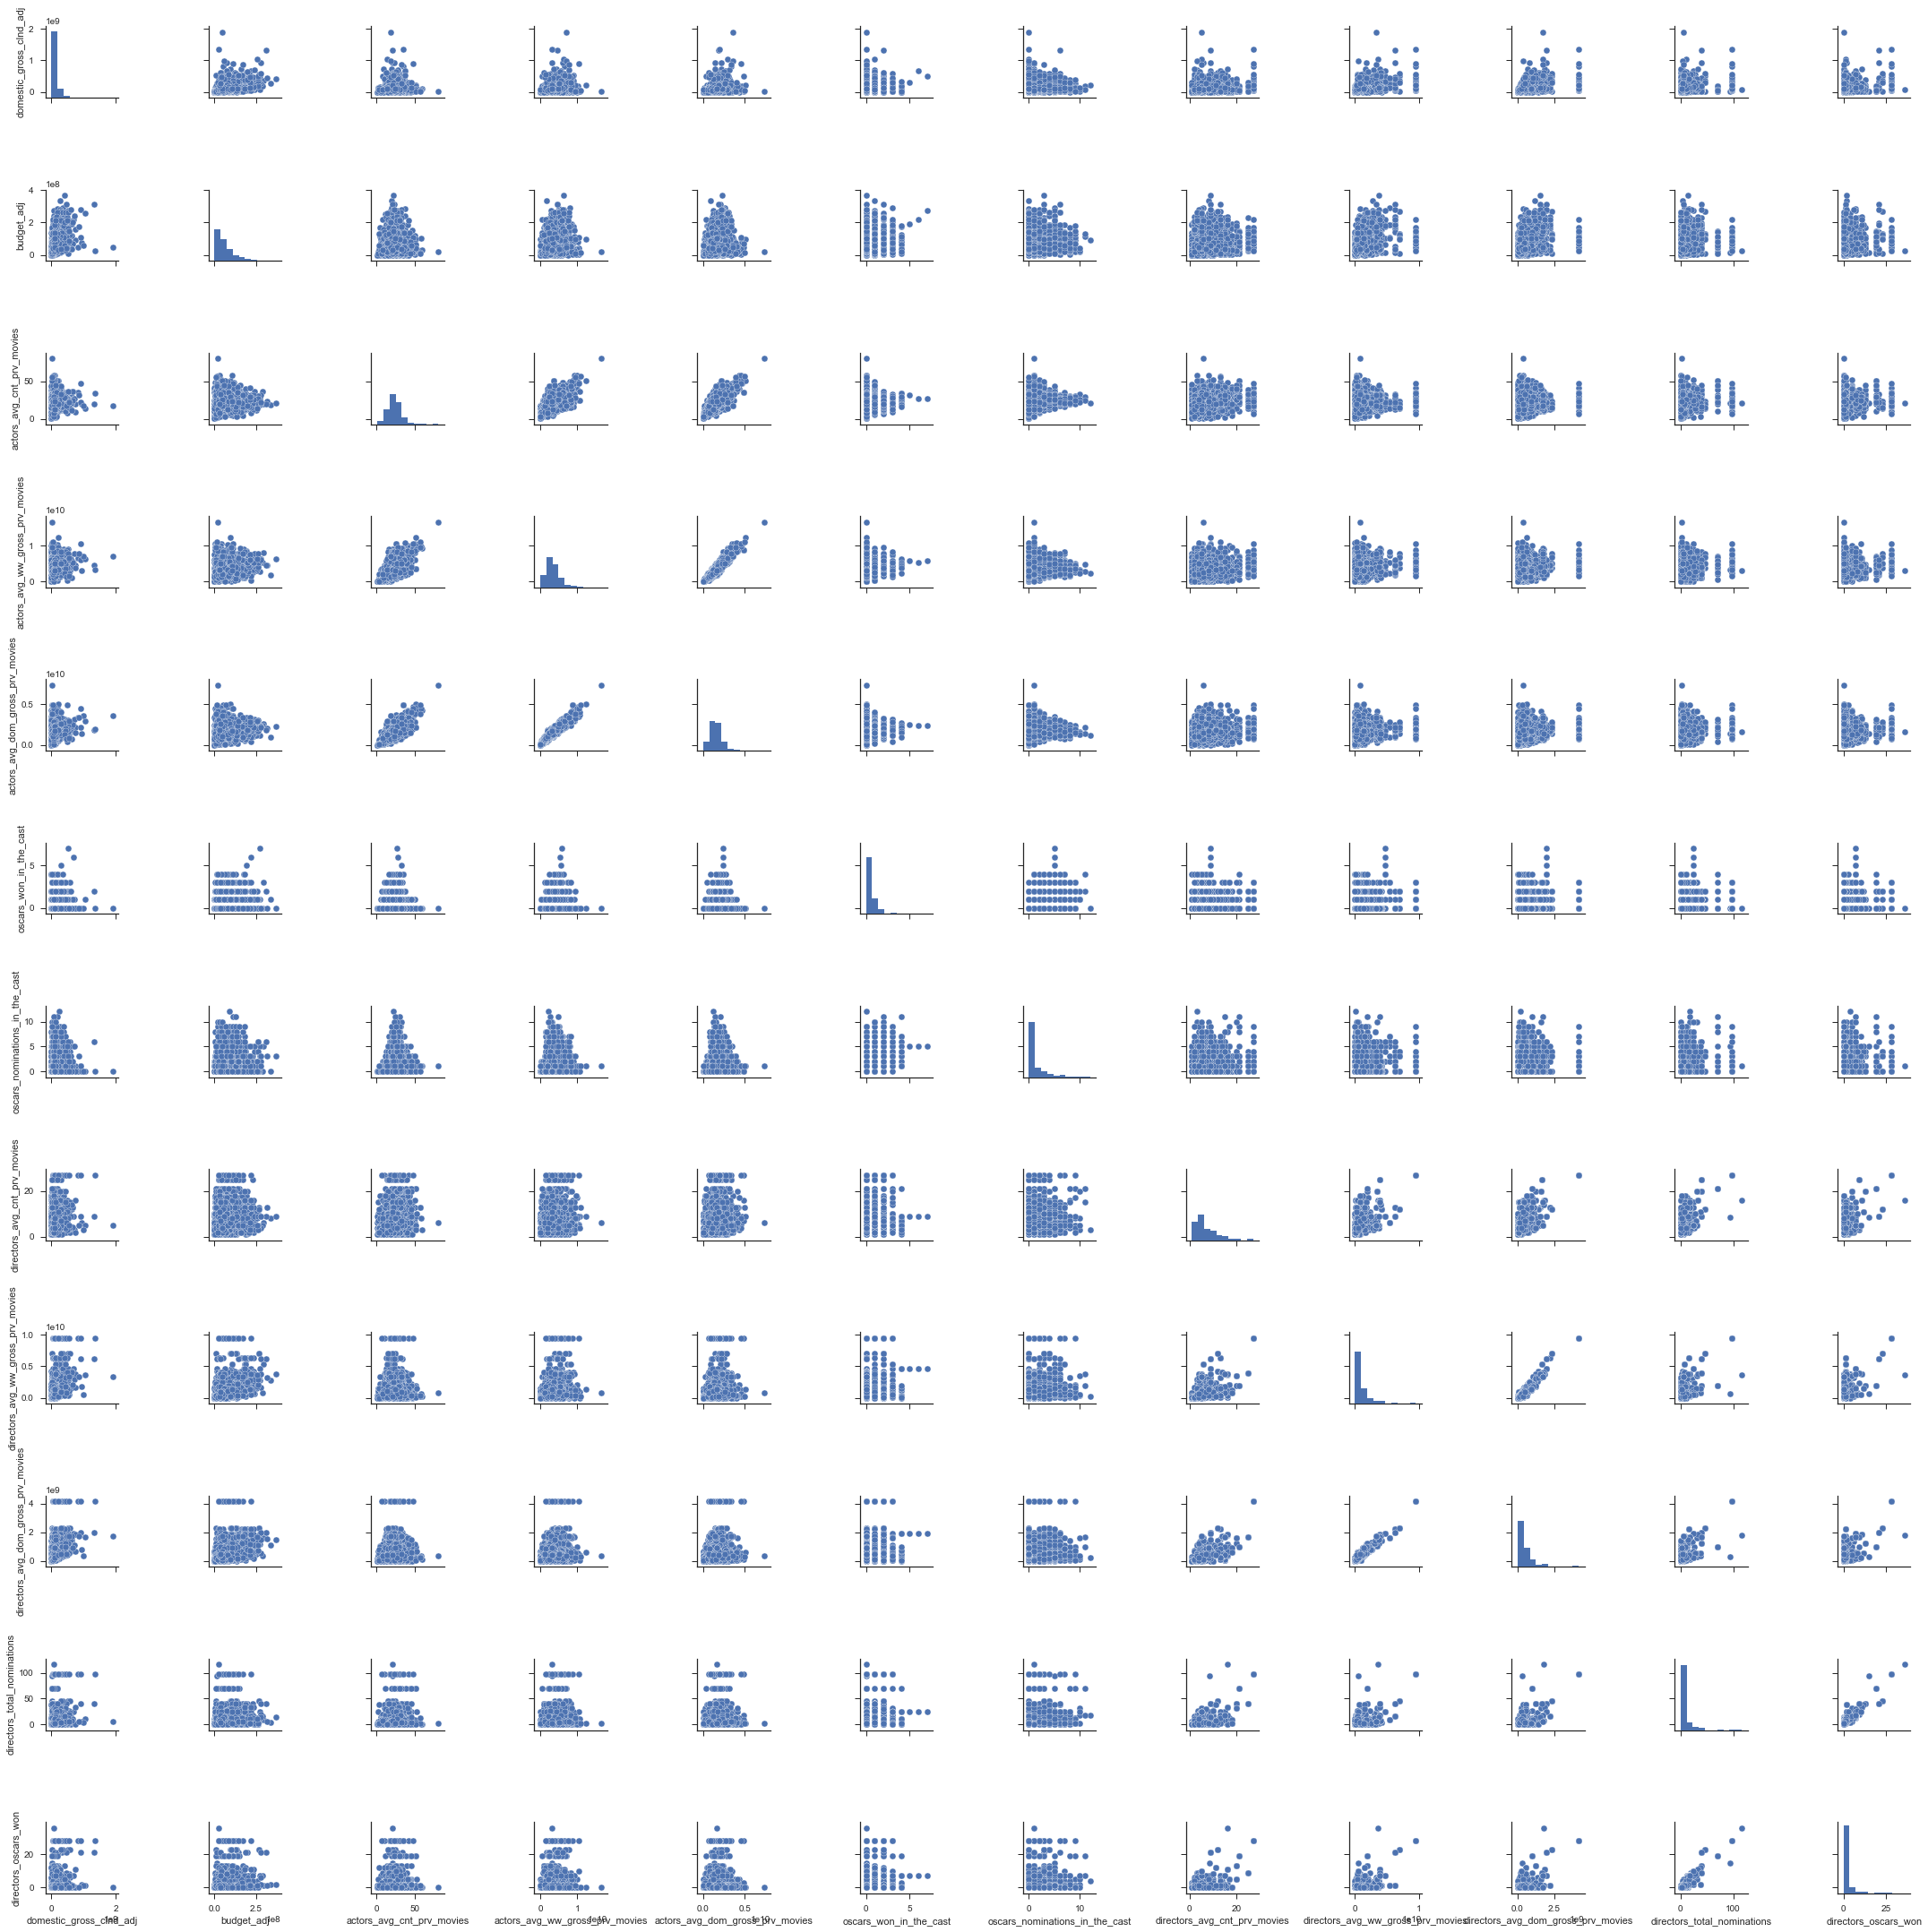

In [104]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
A=df[columns_to_display]
g = sns.pairplot(
    A
)
plt.tight_layout()
plt.savefig('demo10BEFORE.png', transparent=True,dpi=300)
plt.show()

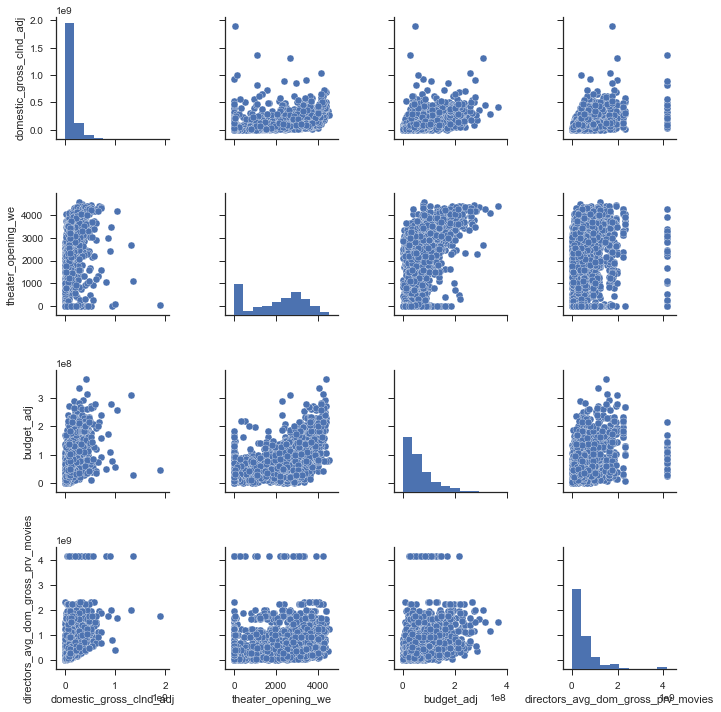

In [105]:
A=df[["domestic_gross_clnd_adj","theater_opening_we",
 "budget_adj","directors_avg_dom_gross_prv_movies"]]
plot = sns.pairplot(A)

## Normalization and Box cox transform

In [106]:
from sklearn import preprocessing
from scipy import stats
lambdas_dict=dict()
def optimal_lambda(x):
    return(np.max(stats.boxcox_normmax(x, method='all')))

def box_cox_mine(x,lamb):
    if lmbda==0:
        return(log(x))
    else:
        return((x**lmbda - 1) / lmbda)
df[columns_to_keep+["domestic_gross_clnd_adj"]]=preprocessing.normalize(df[columns_to_keep+["domestic_gross_clnd_adj"]], axis=0)    
for column in columns_to_keep+["domestic_gross_clnd_adj"]:
    try:
        lmbda=optimal_lambda(df[column])
        df[column]=df[column].apply(lambda x: box_cox_mine(x,lmbda))
        lambdas_dict[column]=lmbda
    except:
        continue
   

Text(0,0.5,'Domestic gross adjusted (box_cox)')

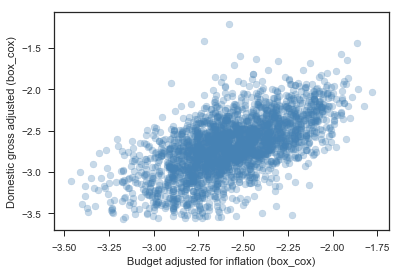

In [107]:
# plot budjet vs dep var in the box plot space
plt.scatter(df["budget_adj"],df["domestic_gross_clnd_adj"],color="SteelBlue",alpha=0.3)
plt.xlabel("Budget adjusted for inflation (box_cox)")
plt.ylabel("Domestic gross adjusted (box_cox)")
# much better

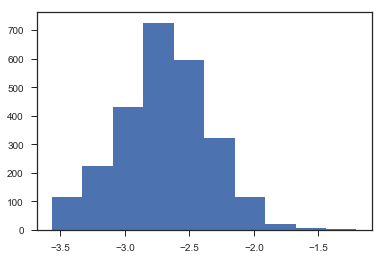

In [108]:
# Bell shapd now
plt.hist(df["domestic_gross_clnd_adj"]);

## Interacions


In [112]:
inter_col_names=[]
for column in columns_to_keep:
    df["budg_and_"+column] = df["budget_adj"] * df[column]
    inter_col_names.append("budg_and_"+column)
columns_to_keep.extend(inter_col_names)


# Phase 5: fit models

In [113]:
X=df[columns_to_keep]

In [114]:
y=df["domestic_gross_clnd_adj"]


In [115]:
X.shape

(2557, 310)

In [116]:
seed=1212
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=seed)


In [117]:
lr=LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


0.8621977940887683

In [118]:
rcv = RidgeCV(cv=10,normalize=True)
rcv.fit(X_train, y_train)
rcv.score(X_train, y_train)
rcv.score(X_test, y_test)

0.8563983514447648

In [119]:
lcv=LassoCV(cv=10,normalize=True)
lcv.fit(X_train, y_train)
print(lcv.score(X_train, y_train))
print(lcv.score(X_test, y_test))

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.8804365974084555
0.8730273736853853


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [145]:
# the three of them gives similar results.
# No overfitting since R2 in train is similar to R2 in test
# I pick up Lasso for the feature selection characteristic

In [123]:
# functions to invert the coxbox
def invert_point_boxplox(x,lmbda):
    return(np.power((x*lmbda+1),(1/lmbda)))

def box_cox_invert(X):
    for column in X.columns:
        try:
            X[column]=X[column].apply(lambda x: invert_point_boxplox(x,lambdas_dict[column]))
        except:
            continue

In [ ]:
# Train a lasso with 5kfold and a user defined range of alpha

In [124]:
from sklearn.linear_model import Lasso
kf = KFold(len(X),n_folds=5, shuffle=True)

all_scores_inverted=[]
all_scores=[]
alphas=[0.000000001,0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1]
all_r2_test=np.zeros(len(alphas))
all_r2_train=np.zeros(len(alphas))  
for train, test in kf:
    x_train=X.iloc[train]
    y_train=y.iloc[train]
    x_test=X.iloc[test]
    y_test=y.iloc[test]
    mse_score=[]
    mse_score_inverted=[]
    
    r2=[]
    r2_train=[]
    r2_transformed=[]
    r2_train_transformed=[]
    for a in alphas:
        est=Lasso(alpha=a,tol=0.001)
        est.fit(x_train,y_train)
        mse=np.mean((y_test-est.predict(x_test))**2)
        mse_score.append(mse)
        
        r2.append(est.score(x_test,y_test))
        r2_train.append(est.score(x_train,y_train))
        
        y_test_inverted=pd.Series(y_test).apply(lambda x: invert_point_boxplox(x,lambdas_dict["domestic_gross_clnd_adj"]))  
        y_predicted=pd.Series(est.predict(x_test)).apply(lambda x: invert_point_boxplox(x,lambdas_dict["domestic_gross_clnd_adj"]))
        y_test_inverted_mean=np.mean(y_test_inverted)
        r2_transformed.append([1-np.sum((y_test_inverted-y_predicted)**2)/np.sum((y_test_inverted-y_test_inverted_mean)**2)])
        
        mse_inverted=np.mean((y_test_inverted-y_predicted)**2)
        mse_score_inverted.append(mse_inverted)
    all_r2_test+=np.array(r2)
    all_r2_train+=np.array(r2_train)
    all_scores.append(mse_score)
    all_scores_inverted.append(mse_score_inverted)
#all_scores

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


No handles with labels found to put in legend.


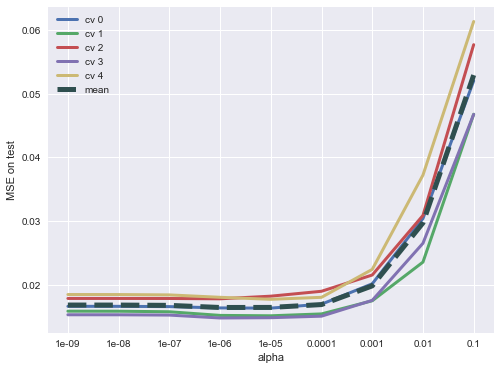

In [126]:
# Plot MSE in the box-cox space

plt.figure(figsize=(8,6))
#plt.ylim(0,0.1)
sns.set()
plt.legend()
for i in range(5):
    plt.plot(all_scores[i],label = 'cv %s'%i,linewidth=3)
mean=np.mean(all_scores,axis=0)
plt.plot(mean,label = 'mean', linewidth=5,linestyle="--",color="DarkSlateGray")
plt.xticks( np.arange(len(alphas)), alphas )
    
plt.legend()
plt.ylabel('MSE on test')
plt.xlabel('alpha')

plt.savefig('demo2.png', transparent=True) 

No handles with labels found to put in legend.


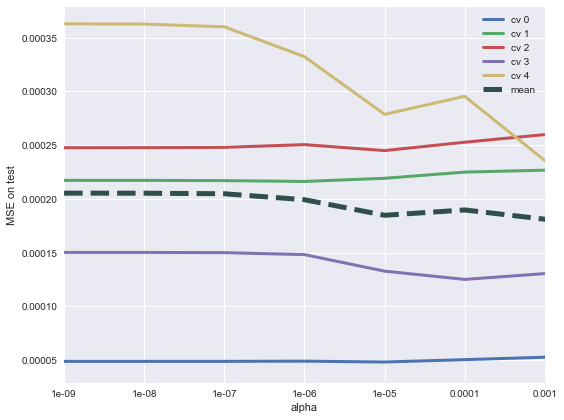

In [127]:
# plot the MSA after inverting the box cox transfoirm
plt.figure(figsize=(8,6))
plt.xlim(0,0.0001)
plt.legend()
for i in range(5):
    plt.plot(all_scores_inverted[i],label = 'cv %s'%i,linewidth=3)
mean=np.mean(all_scores_inverted,axis=0)
plt.plot(mean,label = 'mean', linewidth=5,linestyle="--",color="DarkSlateGray")
plt.xticks( np.arange(7), alphas[:7] )
    
plt.legend()
plt.ylabel('MSE on test')
plt.xlabel('alpha')
plt.tight_layout()
plt.savefig('demo8.png', transparent=True,dpi=300)
plt.show()
plt.show()

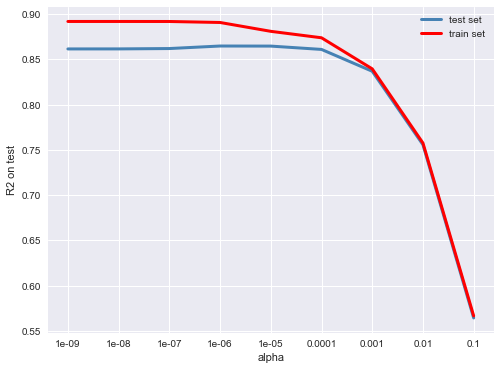

In [129]:
# plot average Train and Test R2 acreoss the 5 folds
plt.figure(figsize=(8,6))

plt.plot(all_r2_test/5,linewidth=3,color="SteelBlue",label="test set")
plt.plot(all_r2_train/5,linewidth=3,color="red", label="train set")
plt.ylabel('R2 on test')
plt.legend()
plt.xlabel('alpha')
plt.xticks( np.arange(len(alphas)), alphas )
plt.savefig('demo.png', transparent=True)   

In [131]:
# BEST R2 ON TEST
all_r2_test[np.argmax(all_r2_test)]/5

0.8646756509976588

In [132]:
# take the optimum alha
optimum_alpha=alphas[np.argmax(all_r2_test)]

In [134]:
# train again the Lasso in a 5-Folds but this time only with the optimal alpha
# and save the coefficients

kf = KFold(len(X),n_folds=5, shuffle=True)
all_folds_results=defaultdict(int)

for train, test in kf:
    x_train=X.iloc[train]
    y_train=y.iloc[train]
    x_test=X.iloc[test]
    y_test=y.iloc[test]
    
    est=Lasso(alpha=optimum_alpha)
    est.fit(x_train,y_train)
    est.alpha

    zipped=zip(X.columns,est.coef_)
    
    
    for f in zipped:
        all_folds_results[f[0]]+=f[1]


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [135]:
# Sort and display the coefficients.
# Since I had normalized them, the absolute value of them
# gives indication of their importance
A=pd.DataFrame(list(all_folds_results.items()),columns=['Feature', 'Coefficient'])
A["Coefficient"]=A["Coefficient"].apply(lambda x: x if x>0 else -x)
A.sort_values(["Coefficient"],ascending=False).head(20)
#all_scores

,Feature,Coefficient
0,theater_opening_we,153.101818
2,international_movie,107.077693
11,oscars_nomination_cleaned,46.481654
16,actors_avg_ww_log_gross_prv_movies,40.346469
157,budg_and_international_movie,32.610162
15,actors_avg_ww_gross_prv_movies,31.058238
166,budg_and_oscars_nomination_cleaned,27.058676
22,directors_avg_ww_gross_prv_movies,25.915464
170,budg_and_actors_avg_ww_gross_prv_movies,22.036313
10,oscars_win_cleaned,18.907164


In [136]:
# replace labels for a better plot
A=A.replace({"Feature":{"theater_opening_we": "No. of theaters in the opening we",
"international_movie": "International movie (y/n)",
"oscars_nomination_cleaned":  "Movie's nominations to Oscars",
"actors_avg_ww_log_gross_prv_movies": "Weigthed average of cast's prev. movies dom. gross", 
"budg_and_international_movie":   "Adjusted budget x int. movie",
"actors_avg_ww_gross_prv_movies":  "Weigthed average of cast's prev. movies WW gross",
"budg_and_oscars_nomination_cleaned":  "Adjusted budget x Oscar nominations",
"directors_avg_ww_gross_prv_movies":   "Director's average WW gross in previous movies",
"budg_and_actors_avg_ww_gross_prv_movies": "Adjusted budget x W.ed avg. cast's WW gross", 
"oscars_win_cleaned":"Oscars prizes won by the movie"}})

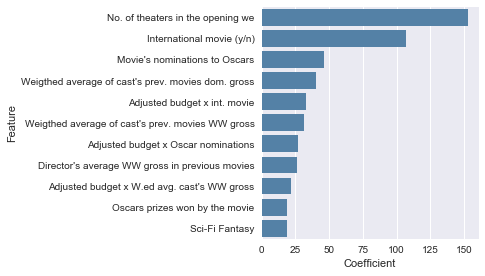

In [137]:
# plt of coefficient importance
plt.figure(figsize=(7,4))
sns.barplot(x="Coefficient", y='Feature', data=A.sort_values(["Coefficient"],ascending=False).head(11), color="SteelBlue")
plt.tight_layout()
plt.savefig('demo3.png', transparent=True,dpi=300) 

# Phase 6: Model assesment

In [138]:
# build prediction 
X['predict']=est.predict(X)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


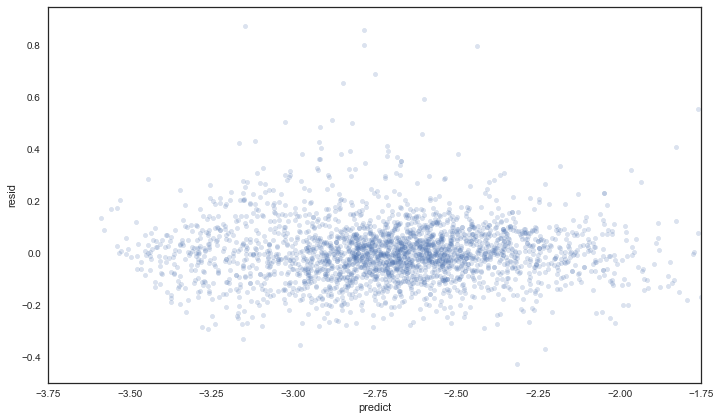

In [146]:
# calculate residuals and plot
# bell shaped, centered around 0, homoscedastics. OK! 
X['resid']=y-X.predict
with sns.axes_style('white'):
    plot=X.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))
plt.tight_layout()
plt.xlim([-3.75,-1.75])
plt.savefig('demo4.png', transparent=True,dpi=300)

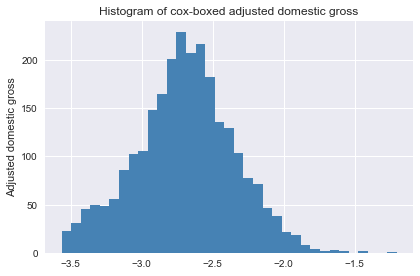

In [140]:
# plot the dep var: bell shaped
sns.set()
y.hist(bins=35,color="SteelBlue")
plt.title("Histogram of cox-boxed adjusted domestic gross")
plt.ylabel('Adjusted domestic gross')
plt.tight_layout()
plt.savefig('demo5.png', transparent=True,dpi=300)
plt.show()

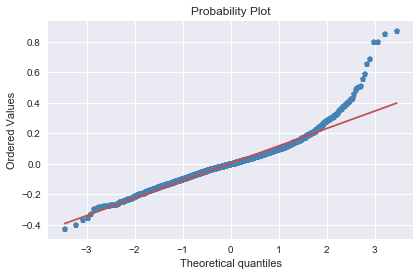

In [141]:
# Q-Q plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title("Normal Q-Q plot")

res = stats.probplot(X['resid'], dist="norm", plot=plt)

ax.get_lines()[0].set_marker('p')
ax.get_lines()[0].set_markerfacecolor('SteelBlue')

plt.tight_layout()
plt.savefig('demo6.png', transparent=True,dpi=300)
plt.show()

In [ ]:
# to find the models before the Oscar night,
# run again this notebook, removing 
# 'oscars_win_cleaned' and 'oscars_nomination_cleaned'
# from the list columns_to_keep at the beginning of phase 4

# to build the model before the release date, 
# remove also  'theater_opening_we' & 'gross_opening_we_adj'

# to build the model at the conceptal stage, remove also all the
# dummies relative to mpaa, teh run time and the release month